In [15]:
%config Completer.use_jedi = False

In [16]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [77]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.demands = problemData['demands']
        self.maximum_vehicle_amount = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MAXIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.objective_functions=problemData['objective_functions']
        self.constraint_functions= problemData['constraint_functions']
        self.number_of_variables = problemData['number_of_cities']
        #self.start_positions = problemData['starts']
        #self.end_positions = problemData['ends']
        self.depot = 0
    

    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        permutation = solution.variables
        capacity = self.vehicle_capacities[0]
        paths = [0]
        current_load = 0
        for node_index in permutation:
            load = current_load + self.demands[node_index]
            
            if load <= capacity:
                paths.append(node_index)
                current_load = load
            
            else:
                # Return to depot
                paths.append(0)
                current_load = 0
        # Start new route
        paths.append(0)
            
        for node_index in range(len(paths)-1):
            from_node = paths[node_index]
            to_node = paths[node_index + 1]
            fitness += self.distance_matrix[from_node][to_node]
            
        solution.objectives[0] = fitness
        solution.path=paths
        return solution
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        permutation = solution.variables
        capacity = self.vehicle_capacities[0]
        paths = [0]
        current_load = 0
        
        for node_index in permutation:
            load = current_load + self.demands[node_index]
            
            if load <= capacity:
                paths.append(node_index)
                current_load = load
            else:
                #Return to depot
                #paths.append(0)
                current_load = 0
        #Start new route
        paths.append(0)
        j = 0
        for node_index in range(len(paths)-1):
            if paths[node_index] == 0:
                j = j+1
                print("route ",j," -> ","Depot ",end=' ')
            else:
                print("city ",paths[node_index],end=' ')
                if paths[node_index+1] == 0:
                    print("Depot")
    
    
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
        
    def get_name(self):
        return 'VRP'

In [78]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
distance_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

In [79]:
distance_matrix_here

,0,1,2,3,4,5,6,7,8,9,10
0,0,45393,207069,60200,199106,18838,98552,355231,336303,94619,70840
1,41374,0,162009,40816,330198,43528,94453,346136,327208,90520,28043
2,206972,161766,0,145180,427976,205415,170963,443914,424986,165338,124482
3,59852,39266,145518,0,306560,58295,53849,322498,303570,49916,34495
4,195907,237797,357810,220005,0,179512,226887,90070,31561,235818,255398
5,18498,44261,205937,59068,193895,0,90488,348142,228923,93487,69708
6,97304,88192,169037,54036,283088,95747,0,299026,280098,9101,81099
7,356334,347222,444568,329430,90529,354777,299620,0,84501,308551,356630
8,337503,351012,425737,307643,31638,330205,280789,83971,0,289720,337799
9,94723,90085,164810,49809,291160,93166,8859,307098,288170,0,76872


In [80]:

starts =[0]
vehicle_amount = 2

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
#customer_demands[ends] = 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = make_open_problem(distance_matrix_here,starts)

#distance_matrix = make_open_problem(squareform(pdist(points_coordinate)),starts)

#depot = 0


data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Distance'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'startpoints':[0],'endpoints':[0]}



# data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
#                    'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


In [81]:
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
#from jmetal.algorithm.multiobjective.
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations

problem = VRP(data_model_input)
max_evaluations = 1000
algorithm = NSGAII(problem=problem,population_size=100,
                   offspring_population_size=100,
                   mutation=PermutationSwapMutation(0.1),
                   crossover=PMXCrossover(0.9),
                   termination_criterion=StoppingByEvaluations(max_evaluations)
)
algorithm.run()
solutions = algorithm.get_result()

In [82]:
k = solutions[-1]
k.path

[0, 1, 3, 0, 8, 7, 4, 5, 0, 6, 9, 10, 0]

In [83]:
distances = []
for sol in solutions:
    distances.append(sol.objectives[0])


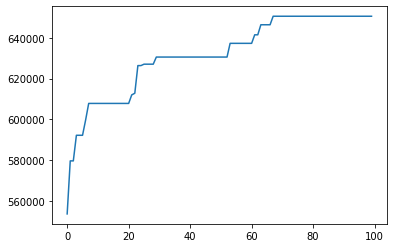

In [84]:

from jmetal.lab.visualization.plotting import Plot
from jmetal.util.solution import get_non_dominated_solutions
import matplotlib.pyplot as plt
front = get_non_dominated_solutions(solutions)

#plot_front = Plot('Pareto front approximation')#, axis_labels=[ 'Distance'])
#plot_front.plot(distances, label='NSGAII-VRP')
plt.plot(distances)

In [76]:
for i in range(len(front)):
    #print("Solution" ,i+1,"no of vehicle=",front[i].objectives[0],"distance=",front[i].objectives[1])  
    problem.get_route(front[i])

route  1  ->  Depot  city  8 city  4 city  5 Depot
route  2  ->  Depot  city  10 city  3 city  9 city  6 Depot
route  3  ->  Depot  city  2 city  1 Depot
